<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/cnn-experiment/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

Instructions on how to run on an ESP32 are here: https://github.com/lisaong/stackup-workshops/tree/master/mask-or-not

In [17]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
   creating: data/mask/
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
   creating: data/no_mask/
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [18]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

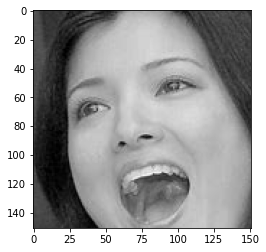

In [19]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [20]:
detect(face_cascade, './data/mask/1.jpg')

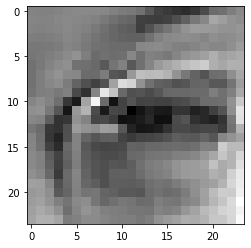

In [21]:
detect(eye_cascade, './data/mask/1.jpg')

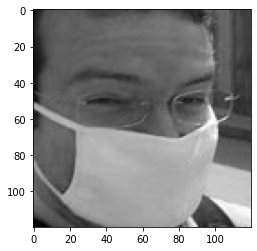

In [22]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

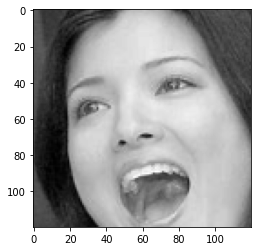

In [23]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

10.jpg


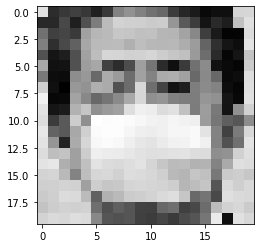

4.jpg


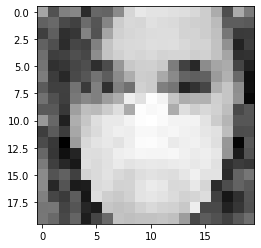

7.jpg


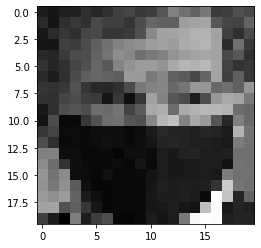

9.jpg


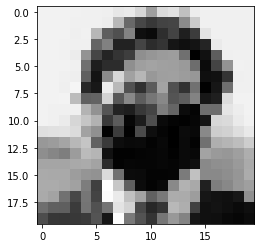

8.jpg


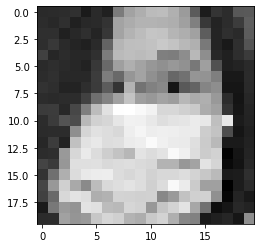

2.jpg


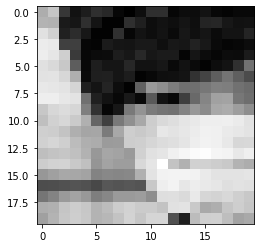

3.jpg


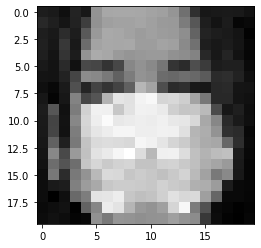

6.jpg


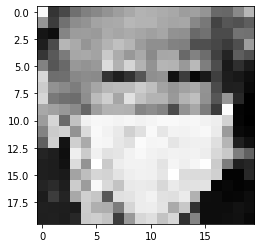

5.jpg


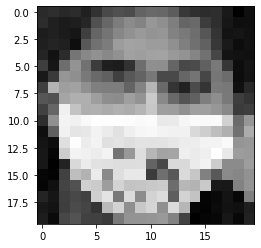

1.jpg


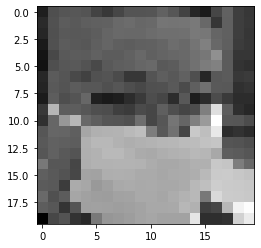

(10, 20, 20)

In [24]:
# Reduce to a small data size so that PCA and the model can fit on ESP32's memory
OUTPUT_SIZE = (20, 20)

def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=OUTPUT_SIZE)))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

10.jpg


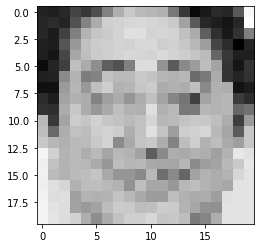

4.jpg


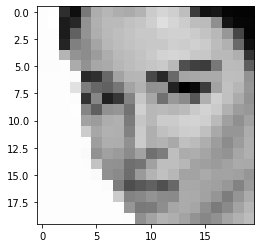

7.jpg


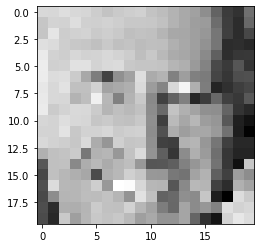

9.jpg


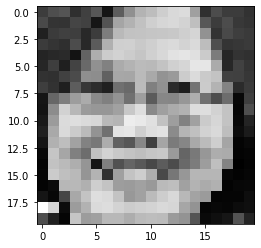

8.jpg


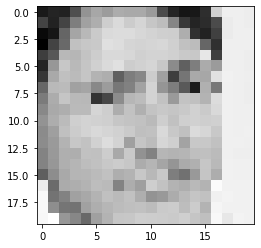

2.jpg


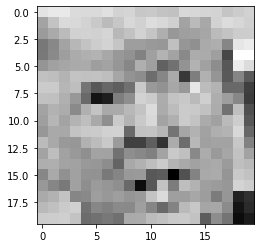

3.jpg


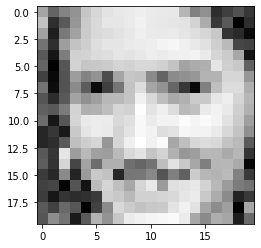

6.jpg


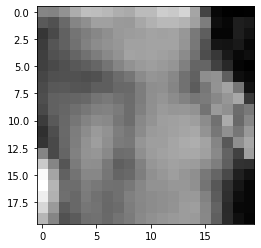

5.jpg


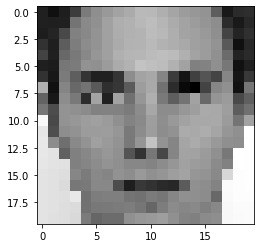

1.jpg


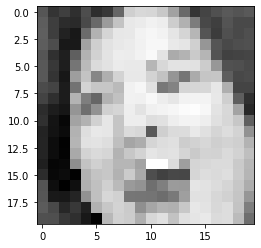

(10, 20, 20)

In [25]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [26]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [27]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 20, 20)

In [28]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 400)

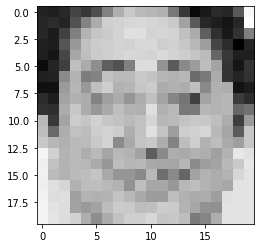

In [29]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [30]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.23795012, 0.16425458, 0.14651591, 0.09359515, 0.05668574,
       0.05332879, 0.03568424, 0.03177791, 0.02998186, 0.0244627 ,
       0.02126411, 0.01835131, 0.017234  , 0.01524179, 0.01400672])

In [31]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

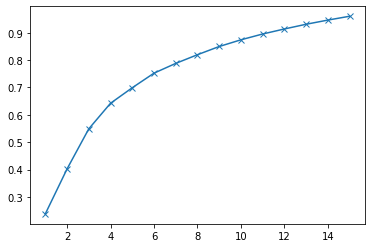

In [32]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [33]:
# choose 7 features
pca = PCA(n_components=7)
Z = pca.fit_transform(X_scaled)

In [34]:
# let's do a pairplot
# df = pd.DataFrame(Z)
# df['label'] = labels
# sns.pairplot(df, hue='label')

In [35]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [38]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Neural Networks

In [39]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [40]:
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=80,
                  validation_data=(X_test, y_test))

Epoch 1/80
3/3 [==============================] - 0s 67ms/step - loss: 2.3805 - accuracy: 0.4000 - val_loss: 0.9899 - val_accuracy: 0.4000
Epoch 2/80
3/3 [==============================] - 0s 11ms/step - loss: 2.2862 - accuracy: 0.4000 - val_loss: 0.9468 - val_accuracy: 0.4000
Epoch 3/80
3/3 [==============================] - 0s 13ms/step - loss: 2.1842 - accuracy: 0.4000 - val_loss: 0.9044 - val_accuracy: 0.4000
Epoch 4/80
3/3 [==============================] - 0s 11ms/step - loss: 2.1078 - accuracy: 0.4000 - val_loss: 0.8629 - val_accuracy: 0.4000
Epoch 5/80
3/3 [==============================] - 0s 11ms/step - loss: 2.0244 - accuracy: 0.4000 - val_loss: 0.8246 - val_accuracy: 0.4000
Epoch 6/80
3/3 [==============================] - 0s 12ms/step - loss: 1.9469 - accuracy: 0.4000 - val_loss: 0.7908 - val_accuracy: 0.6000
Epoch 7/80
3/3 [==============================] - 0s 12ms/step - loss: 1.8563 - accuracy: 0.4000 - val_loss: 0.7621 - val_accuracy: 0.6000
Epoch 8/80
3/3 [===========

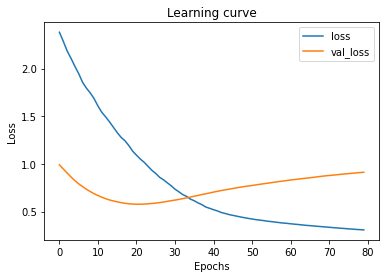

In [41]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [42]:
mlp.save('mlp.h5')

In [43]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [44]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



## Convolutional Neural Networks

10.jpg


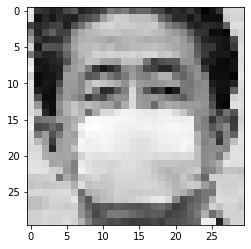

4.jpg


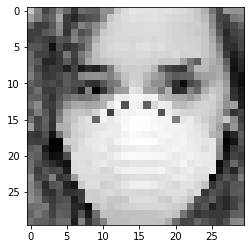

7.jpg


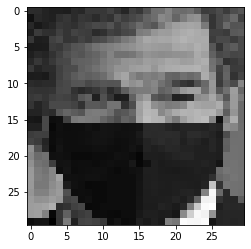

9.jpg


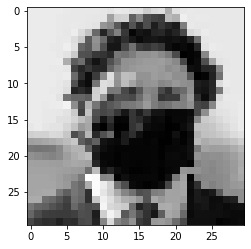

8.jpg


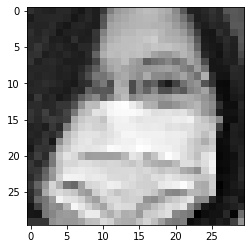

2.jpg


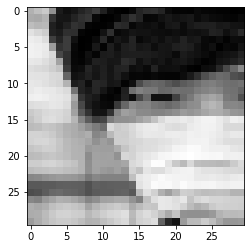

3.jpg


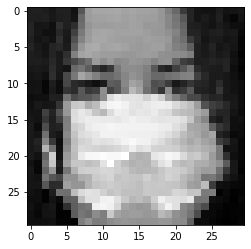

6.jpg


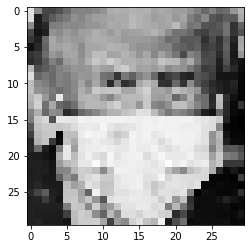

5.jpg


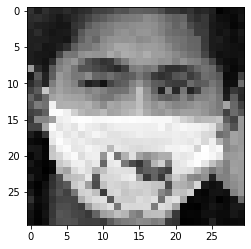

1.jpg


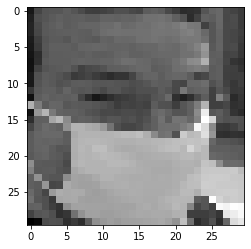

10.jpg


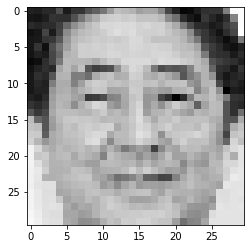

4.jpg


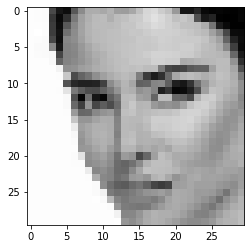

7.jpg


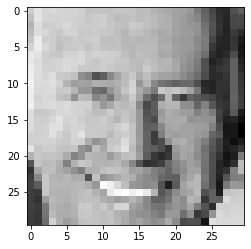

9.jpg


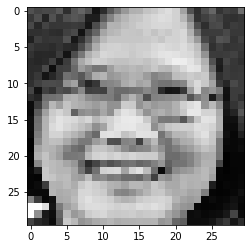

8.jpg


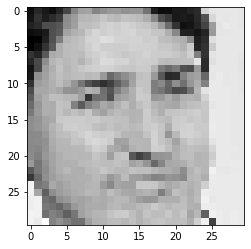

2.jpg


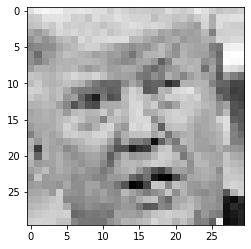

3.jpg


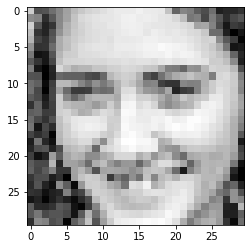

6.jpg


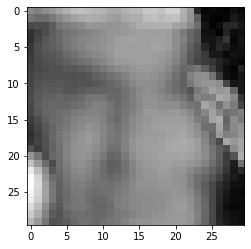

5.jpg


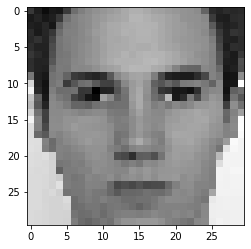

1.jpg


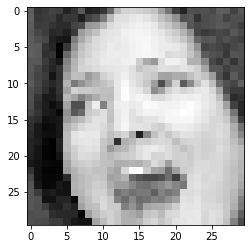

In [45]:
# try a conv net, maybe larger input size we have fewer weights

OUTPUT_SIZE = (30, 30)
images_mask = get_image_data('mask')
images_nomask = get_image_data('no_mask')
images = np.vstack([images_nomask, images_mask])

X_30x30 = images.reshape(-1, images.shape[1]*images.shape[2])

In [46]:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X_30x30)

X_scaled_reshape = X_scaled.reshape(-1, images.shape[1], images.shape[2], 1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshape, y, 
                                                    random_state=42, stratify=y)
X_train.shape

(15, 30, 30, 1)

In [71]:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
cnn = tf.keras.Sequential()
cnn.add(layers.SeparableConv2D(5, 3, 
        input_shape=(X_train.shape[1],X_train.shape[2], 1), activation='relu'))
cnn.add(layers.MaxPool2D())
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 28, 28, 5)         19        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 5)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 980)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 981       
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________


In [72]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, batch_size=5, epochs=30,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop])

Epoch 1/30
3/3 [==============================] - 0s 38ms/step - loss: 0.7138 - accuracy: 0.4000 - val_loss: 0.8164 - val_accuracy: 0.2000
Epoch 2/30
3/3 [==============================] - 0s 12ms/step - loss: 0.6288 - accuracy: 0.6667 - val_loss: 0.7889 - val_accuracy: 0.2000
Epoch 3/30
3/3 [==============================] - 0s 12ms/step - loss: 0.5656 - accuracy: 0.7333 - val_loss: 0.7517 - val_accuracy: 0.6000
Epoch 4/30
3/3 [==============================] - 0s 12ms/step - loss: 0.5112 - accuracy: 0.7333 - val_loss: 0.7349 - val_accuracy: 0.6000
Epoch 5/30
3/3 [==============================] - 0s 12ms/step - loss: 0.4576 - accuracy: 0.7333 - val_loss: 0.7249 - val_accuracy: 0.6000
Epoch 6/30
3/3 [==============================] - 0s 13ms/step - loss: 0.4112 - accuracy: 0.8667 - val_loss: 0.7175 - val_accuracy: 0.6000
Epoch 7/30
3/3 [==============================] - 0s 11ms/step - loss: 0.3714 - accuracy: 0.8667 - val_loss: 0.7129 - val_accuracy: 0.8000
Epoch 8/30
3/3 [===========

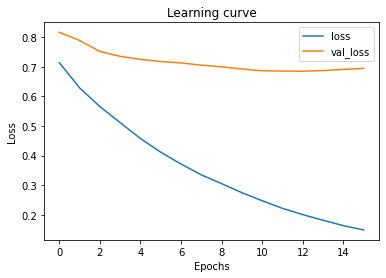

In [73]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [75]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('cnn.tflite', 'wb').write(tflite_model)

6096

In [76]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='cnn.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [77]:
!pip install tinymlgen

  Created wheel for tinymlgen: filename=tinymlgen-0.2-cp36-none-any.whl size=2245 sha256=92af05e91af473bbc3d6588418c678e51fd310b1ae9770438efb353beaaea8db
  Stored in directory: /root/.cache/pip/wheels/a1/84/4d/3c1a67c7b9483e296ff1b2f4a13e2f800ca2a6093b741450d2
  Created wheel for hexdump: filename=hexdump-3.3-cp36-none-any.whl size=8914 sha256=e8e7ead60868e730b44eb1902665bfc79630df08f2ace2d135fb3f38904c02a4
  Stored in directory: /root/.cache/pip/wheels/d5/d1/f2/c8183b5863b3df595c2eeafd8e015a43dae13d403a959467c6
Successfully built tinymlgen hexdump


In [83]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(mlp)

input_shape = OUTPUT_SIZE[0]*OUTPUT_SIZE[1]

with open('cnn.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define NUMBER_OF_INPUTS {input_shape}\n')
  f.write(f'#define NUMBER_OF_OUTPUTS {cnn.get_output_shape_at(0)[1]}\n')

In [84]:
with open('cnn.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x4e, 0xfd, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x10, 0x07, 0x00, 0x00, 0x9c, 0x02, 0x00, 0x00, 0x84, 0x02, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x74, 0x02, 0x00, 0x00, 0x6c, 0x02, 0x00, 0x00, 0x40, 0x02, 0x00, 0x00, 0x0c, 0x02, 0x00, 0x00, 0xf8, 0x01, 0x00, 0x00, 0x24, 0x01, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x58, 0xf9, 0xff, 0xff, 0x5c, 0xf9, 0xff, 0xff, 0x60, 0xf9, 0xff, 0xff, 0x64, 0xf9, 0xff, 0xff, 0xfe, 0xfd, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x1c, 0x00,

## Port PCA to Arduino

https://eloquentarduino.github.io/2020/06/arduino-dimensionality-reduction-pca-for-machine-learning-projects/

In [85]:
!pip install micromlgen

  Created wheel for micromlgen: filename=micromlgen-1.1.2-cp36-none-any.whl size=11256 sha256=456e9833bd4b8f7277a88f91475f6df6903c6563d29fd37c7dd0f86b25198bfa
  Stored in directory: /root/.cache/pip/wheels/13/4d/83/d20a7754ef19d92a17f1da204b30ca890b58a363c51139d1a5
Successfully built micromlgen


In [86]:
import micromlgen

c_code = micromlgen.port(pca)
with open('pca.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define PCA_INPUT_SIZE {OUTPUT_SIZE[0]*OUTPUT_SIZE[1]}\n')

In [87]:
with open('pca.h', 'r') as f:
  print(f.read())

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[7] = { 0 };
                        u[0] = dot(x,   0.009745232911  , 0.040000584354  , 0.037997422895  , 0.034423291992  , 0.047695117338  , 0.035080827361  , 0.032851186065  , 0.009831912302  , -0.010915658149  , -0.024162293427  , -0.039798605596  , -0.014179516541  , 0.003418074705  , 0.007892753752  , 0.027666947  , 0.039567288155  , 0.02932477692  , 0.037270220262  , 0.012983036561  , 0.00840205719  , 0.0303948036  , 0.037882054129  , 0.043333548582  , 0.046022804212  , 0.036001428396  , 0.029817124344  , 0.007549063057  , -0.035889410189  , -0.065687985026  , -0.06591257589

In [88]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'tf_filename' : 'cnn.h5', 
    'tflite_filename': 'cnn.tflite',
    'h_filename' : 'cnn.h',
    'X_pca_h_filename' : 'pca.h'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))